# Energy and Accuracy Comparison

This notebook compares:
- Baseline CNN accuracy
- SNN accuracy for different simulation lengths T
- A simple spike-based energy proxy

In [1]:
# Cell 1: Imports and paths
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as T
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf

import snntorch as snn
from snntorch import surrogate

PROJECT_ROOT = Path.cwd().resolve()
DATA_ROOT = PROJECT_ROOT / "sample_data" / "speech_commands_v0.02"
MODEL_DIR = PROJECT_ROOT / "saved_models"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT exists:", DATA_ROOT.exists())
print("MODEL_DIR exists:", MODEL_DIR.exists())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

CLASSES = ["yes", "no", "go", "stop", "down", "up"]
SAMPLE_RATE = 16000
N_MFCC = 40

PROJECT_ROOT: /Users/maddy/Desktop/PLEP/Project/CS-576-Final-Project_backup
DATA_ROOT exists: True
MODEL_DIR exists: True
Using device: cpu


In [2]:
# Cell 2: Model definitions
class CNN_KWS(nn.Module):
    def __init__(self, num_classes=6, flatten_dim=3840):
        super().__init__()
        self.flatten_dim = flatten_dim

        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        x = torch.flatten(x, 1)
        Fdim = x.shape[1]
        if Fdim > self.flatten_dim:
            x = x[:, :self.flatten_dim]
        elif Fdim < self.flatten_dim:
            pad = self.flatten_dim - Fdim
            x = F.pad(x, (0, pad))
        return self.classifier(x)

spike_grad = surrogate.fast_sigmoid()

class SNN_KWS(nn.Module):
    def __init__(self, base_cnn: CNN_KWS, num_steps: int = 50, beta: float = 0.95):
        super().__init__()
        self.num_steps = num_steps
        self.features = base_cnn.features
        self.fc1 = base_cnn.classifier[0]
        self.fc2 = base_cnn.classifier[2]

        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):
        spk2_rec = []
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        x = x.unsqueeze(1)

        for _ in range(self.num_steps):
            cur = self.features(x)
            cur = torch.flatten(cur, 1)
            cur = F.relu(self.fc1(cur))
            spk1, mem1 = self.lif1(cur, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

In [3]:
# Cell 3: Load models
cnn_ckpt_path = MODEL_DIR / "baseline_cnn_kws_vfinal.pt"
snn_ckpt_path = MODEL_DIR / "snn_kws_beta0.95_T50.pt"

print("CNN checkpoint exists:", cnn_ckpt_path.exists())
print("SNN checkpoint exists:", snn_ckpt_path.exists())

flatten_dim_ckpt = 3840
cnn_model = CNN_KWS(num_classes=6, flatten_dim=flatten_dim_ckpt).to(device)
cnn_state = torch.load(cnn_ckpt_path, map_location=device)
cnn_model.load_state_dict(cnn_state)
cnn_model.eval()

snn_model = SNN_KWS(cnn_model, num_steps=50, beta=0.95).to(device)
if snn_ckpt_path.exists():
    snn_state = torch.load(snn_ckpt_path, map_location=device)
    snn_model.load_state_dict(snn_state)
    print("Loaded SNN weights from snn_kws_beta0.95_T50.pt")
else:
    print("SNN checkpoint not found, using CNN weights only.")
snn_model.eval()

CNN checkpoint exists: True
SNN checkpoint exists: True
Loaded SNN weights from snn_kws_beta0.95_T50.pt


SNN_KWS(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3840, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
  (lif1): Leaky()
  (lif2): Leaky()
)

In [4]:
# Cell 4: MFCC and dataset
mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=N_MFCC,
    melkwargs={
        "n_fft": 400,
        "hop_length": 160,
        "n_mels": 40,
        "center": False,
    },
)

def wav_to_mfcc(path: Path):
    waveform, sr = sf.read(str(path))
    waveform = torch.tensor(waveform).float().unsqueeze(0)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
    mfcc = mfcc_transform(waveform).squeeze(0)
    mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)
    mfcc = torch.clamp(mfcc, -2.0, 2.0)
    return mfcc

class KWS_Dataset(Dataset):
    def __init__(self, root: Path, classes):
        self.paths = []
        self.classes = classes
        for c in classes:
            class_dir = root / c
            self.paths.extend(sorted(class_dir.glob("*.wav")))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        x = wav_to_mfcc(path)
        label = path.parent.name
        y = self.classes.index(label)
        return x, y

def pad_collate(batch):
    xs, ys = zip(*batch)
    maxT = max(x.shape[1] for x in xs)
    xs = [F.pad(x, (0, maxT - x.shape[1])) for x in xs]
    xs = torch.stack(xs)
    ys = torch.tensor(ys)
    return xs, ys

test_dataset = KWS_Dataset(DATA_ROOT, CLASSES)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)

print("Test samples:", len(test_dataset))

Test samples: 23377


In [5]:
# Cell 5: Evaluation helpers
@torch.no_grad()
def eval_cnn(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / max(total, 1)

@torch.no_grad()
def eval_snn_energy(model, loader, device, T):
    model.eval()
    total = 0
    correct = 0
    total_spikes = 0
    total_neurons = 0

    old_steps = model.num_steps
    model.num_steps = T

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        out_TBC = model(x)
        spikes = (out_TBC > 0).float()
        total_spikes += spikes.sum().item()
        total_neurons += spikes.numel()

        logits = out_TBC.sum(dim=0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()

    model.num_steps = old_steps

    acc = correct / max(total, 1)
    avg_spike_rate = total_spikes / max(total_neurons, 1)
    energy = avg_spike_rate * T
    return acc, avg_spike_rate, energy

In [6]:
# Cell 6: Run comparison
T_values = [10, 25, 50, 75, 100]
results = []

print("Evaluating CNN...")
cnn_acc = eval_cnn(cnn_model, test_loader, device)
print(f"CNN Test Accuracy: {cnn_acc*100:.2f}%")

for T in T_values:
    print(f"Evaluating SNN at T={T}...")
    acc, spike_rate, energy = eval_snn_energy(snn_model, test_loader, device, T)
    results.append({
        "model": "SNN",
        "T": T,
        "test_acc": acc * 100,
        "avg_spike_rate": spike_rate,
        "energy_proxy": energy,
    })

df = pd.DataFrame(results)
df_cnn = pd.DataFrame([{
    "model": "CNN",
    "T": "-",
    "test_acc": cnn_acc * 100,
    "avg_spike_rate": 0.0,
    "energy_proxy": 1.0,
}])

df_all = pd.concat([df_cnn, df], ignore_index=True)
display(df_all)

Evaluating CNN...
CNN Test Accuracy: 88.14%
Evaluating SNN at T=10...
Evaluating SNN at T=25...
Evaluating SNN at T=50...
Evaluating SNN at T=75...
Evaluating SNN at T=100...


,model,T,test_acc,avg_spike_rate,energy_proxy
0,CNN,-,88.142191,0.000000,1.000000
1,SNN,10,50.485520,0.066858,0.668577
2,SNN,25,52.290713,0.072843,1.821063
3,SNN,50,52.876759,0.074969,3.748435
4,SNN,75,53.039312,0.075656,5.674210
5,SNN,100,53.052145,0.076028,7.602765


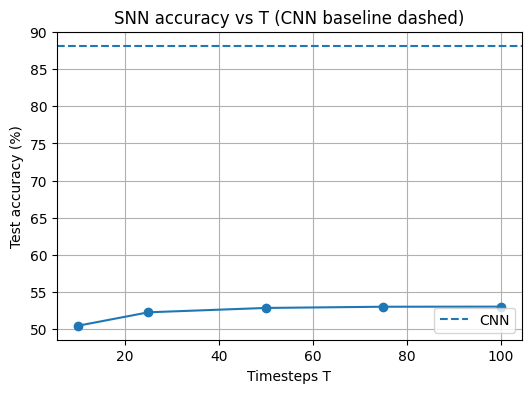

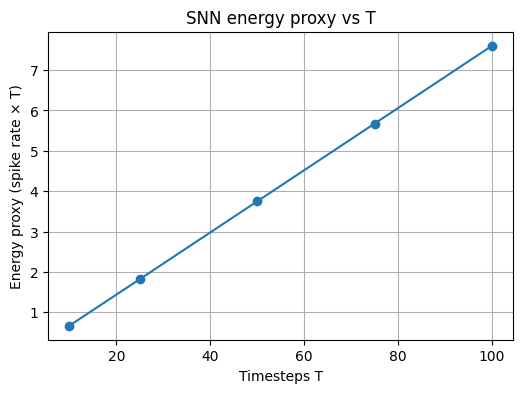

In [7]:
# Cell 7: Plots
plt.figure(figsize=(6, 4))
plt.plot(df["T"], df["test_acc"], marker="o")
plt.axhline(y=cnn_acc*100, linestyle="--", label="CNN")
plt.xlabel("Timesteps T")
plt.ylabel("Test accuracy (%)")
plt.title("SNN accuracy vs T (CNN baseline dashed)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(df["T"], df["energy_proxy"], marker="o")
plt.xlabel("Timesteps T")
plt.ylabel("Energy proxy (spike rate × T)")
plt.title("SNN energy proxy vs T")
plt.grid(True)
plt.show()